We started by setting up the Google Colab environment with GPU support and installed the required libraries. Then, we downloaded and prepared a dataset (Flickr8k) and created a custom PyTorch dataset class to process images. We converted images from RGB to Lab color space, extracting the L channel (grayscale) as input and the ab channels (color) as targets.

Next, we designed a deep learning model using ResNet-18 as an encoder (feature extractor) and a decoder with transposed convolutions to generate color channels. We encountered a few size mismatch errors, which we fixed by adjusting the decoder layers to ensure a 256×256 output size.

Now, the model is training to learn how to predict color information for grayscale images!

In [ ]:
import torch
print("GPU Available: ", torch.cuda.is_available())
print("GPU Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU Available:  True
GPU Name:  Tesla T4


In [ ]:
!pip install torch torchvision numpy opencv-python matplotlib scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from PIL import Image
from tqdm import tqdm

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
# Create dataset directory
!mkdir -p dataset/sample_images

# Download a smaller dataset of 100 images (about 100MB)
!wget -q -O sample_images.zip "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"

# Unzip the dataset (should take about a minute)
!unzip -q sample_images.zip -d dataset/sample_images/

# Remove ZIP file to save space
!rm sample_images.zip

print("Smaller dataset downloaded and extracted successfully!")


replace dataset/sample_images/Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Smaller dataset downloaded and extracted successfully!


In [4]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, "**/*.jpg"), recursive=True)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = img.resize((256, 256))  # Resize images for uniform training

        # Convert to NumPy and Lab color space
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")  # Convert RGB to LAB color space

        L = img_lab[:, :, 0] / 100.0  # Normalize L channel to [0,1]
        ab = img_lab[:, :, 1:] / 128.0  # Normalize ab channels to [-1,1]

        # Convert to PyTorch tensors
        L = torch.from_numpy(L).unsqueeze(0)  # Shape: (1, 256, 256)
        ab = torch.from_numpy(ab).permute(2, 0, 1)  # Shape: (2, 256, 256)

        return L, ab

print("Dataset class created successfully!")


Dataset class created successfully!


In [5]:
# Define dataset path
dataset_path = "dataset/sample_images"

# Create dataset instance
train_dataset = ColorizationDataset(dataset_path)

# Create DataLoader (batch size 8 for efficiency)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Check dataset size
print(f"Total training images: {len(train_dataset)}")


Total training images: 8091


In [14]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        # Load pretrained ResNet18 model
        self.encoder = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Modify first layer to accept 1 channel (grayscale instead of RGB)
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Remove the last fully connected layers (keep only feature extractor)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])

        # Decoder with final upsampling to ensure output size is exactly 256x256
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),    # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),    # 128x128 -> 256x256
            nn.ReLU(),
            nn.Conv2d(16, 2, 3, padding=1),  # Output 2 channels (ab)
            nn.Tanh()  # Normalize output to [-1, 1]
        )

    def forward(self, L):
        features = self.encoder(L)  # Extract features from L channel
        ab_output = self.decoder(features)  # Generate ab channels
        return ab_output

print("Final corrected model defined successfully!")


Final corrected model defined successfully!


In [10]:
# Initialize Model
model = ColorizationModel().cuda()  # Move model to GPU

# Define Loss Function (Mean Squared Error)
criterion = nn.MSELoss()

# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model initialized and moved to GPU!")


Model initialized and moved to GPU!


In [15]:
# Re-initialize the model and move to GPU
model = ColorizationModel().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Restart training
print("Starting training with the final corrected model...")
train_model(model, train_loader, epochs=5)


Starting training with the final corrected model...


Epoch 1/5: 100%|██████████| 1012/1012 [04:05<00:00,  4.13it/s]


Epoch [1/5] - Loss: 13.8037


Epoch 2/5: 100%|██████████| 1012/1012 [04:02<00:00,  4.18it/s]


Epoch [2/5] - Loss: 13.3046


Epoch 3/5: 100%|██████████| 1012/1012 [04:02<00:00,  4.18it/s]


Epoch [3/5] - Loss: 13.1308


Epoch 4/5: 100%|██████████| 1012/1012 [04:04<00:00,  4.14it/s]


Epoch [4/5] - Loss: 12.9407


Epoch 5/5: 100%|██████████| 1012/1012 [04:04<00:00,  4.15it/s]

Epoch [5/5] - Loss: 12.7091


In [16]:
# Save model to disk
torch.save(model.state_dict(), "colorization_model.pth")
print("Model saved successfully!")


Model saved successfully!


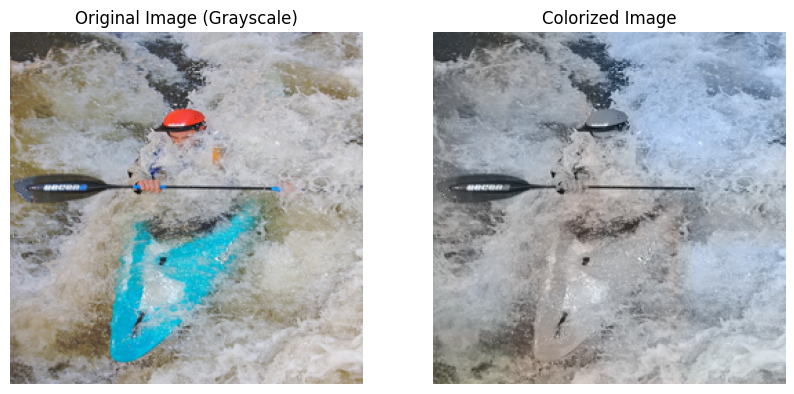

In [17]:
# Function to load and process a test image
def colorize_image(model, image_path):
    model.eval()  # Set model to evaluation mode

    # Load image and convert to grayscale (L channel)
    img = Image.open(image_path).convert("RGB")
    img = img.resize((256, 256))
    img = np.array(img)

    # Convert to LAB color space
    img_lab = rgb2lab(img).astype("float32")
    L = img_lab[:, :, 0] / 100.0  # Normalize L channel to [0,1]

    # Convert to PyTorch tensor
    L_tensor = torch.from_numpy(L).unsqueeze(0).unsqueeze(0).cuda()  # Shape: (1, 1, 256, 256)

    # Run the model to predict `ab` channels
    with torch.no_grad():
        ab_pred = model(L_tensor).cpu().numpy().squeeze()  # Output shape: (2, 256, 256)

    # Rescale ab channels back to original range
    ab_pred = ab_pred * 128.0

    # Merge with L channel
    L = (L * 100).astype("float32")  # Convert back to original scale
    colorized_lab = np.concatenate((L[:, :, np.newaxis], ab_pred.transpose(1, 2, 0)), axis=-1)

    # Convert LAB back to RGB
    colorized_rgb = lab2rgb(colorized_lab)

    # Plot original grayscale vs. colorized image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image (Grayscale)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(colorized_rgb)
    plt.title("Colorized Image")
    plt.axis("off")

    plt.show()

# Choose a test image from the dataset
test_image_path = glob.glob("dataset/sample_images/**/*.jpg", recursive=True)[0]

# Colorize the image
colorize_image(model, test_image_path)
